In [45]:
import torch
import pickle
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, f_classif
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score
from collections import OrderedDict

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)


In [46]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [47]:
with open('dfs_test_list.pkl', 'rb') as file:
    dfs_test = pickle.load(file)

with open('dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

In [48]:
def split_df(dfs):
    new_dfs= []

    for df in dfs:
    
        numero_di_parti = len(df) // 400
        # ottini 3 df, 0-400, 400-800, 800-1200
        for i in range(numero_di_parti):
            parte = df.iloc[i*400 : (i+1)*400]
            new_dfs.append(parte)
            
    return new_dfs

    

In [49]:
dfs_train_task3 = split_df(dfs_train)
dfs_test_task3 = split_df(dfs_test)
# for df in dfs_train:
 
#     numero_di_parti = len(df) // 400
#     # ottini 3 df, 0-400, 400-800, 800-1200
#     for i in range(numero_di_parti):
#         parte = df.iloc[i*400 : (i+1)*400]
#         dfs_train_task3.append(parte)



In [50]:
len(dfs_test)

46

# Analisi spettrale.
calcolo FFT per ogni serie temporale (P1-P7) di ogni caso (1-177)

eliminazione della frequenza 0 (componente DC).

fftfreq calcola le frequenze associate ai coefficienti ottenuti dalla fft.

il plot seguente ha sull'asse x le frequenze e sull'asse y la fft.

per la ftt basta la parte reale o bisogna mantenere anche la fase (parte immaginaria)?


In [51]:
sampling_rate = 1000  # 1 kHz
signal_length_ms = 1200

In [52]:
def calculate_spectral_features(freqs,spectrum):

    signal_power = np.sum(spectrum)
    noise_power = np.sum(spectrum[freqs > 0.5 * sampling_rate])
    distortion_power = signal_power - noise_power 

    epsilon = 1e-10
    snr = 10 * np.log10(signal_power / (noise_power + epsilon))

    sinad = 10 * np.log10(signal_power / (noise_power + distortion_power + epsilon))

    # peak_amplitude = np.max(time_series)

    band_power = np.sum(spectrum[(freqs >= 0) & (freqs <= max(range(len(freqs))))])

    peak_value = np.max(spectrum)

    peak_freq = freqs[np.argmax(spectrum)]

    mean_power_spectrum = np.mean(spectrum)
   

    sum_power_spectrum = np.sum(spectrum)
    std_spectrum = np.std(spectrum)

    return sinad, snr, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum,std_spectrum

def calculate_additional_spectral_features(freqs,spectrum):
    

    harmonic_amplitude_ratio = np.max(spectrum) / np.mean(spectrum)
    main_harmonic_bandwidth = freqs[np.argmax(spectrum)] - freqs[np.argmin(spectrum)]


    return harmonic_amplitude_ratio, main_harmonic_bandwidth

In [53]:
def spectral_features(dfs_data):
    dfs_freq = []
    dfs_fft = []
    freq_dom = []

    for df in dfs_data:
        fft_df = pd.DataFrame()
        # fft_freq = pd.DataFrame()
        freq_dom_col = pd.DataFrame()

        for col in df.columns:
            if  (col != "TIME") and (col != "Case"):
                fft_result = np.fft.fft(df[col]).real
                freq = np.fft.fftfreq(len(df[col]), d=1/sampling_rate)

                # eliminazione componente DC
                fft_result = fft_result[1:]
                freq = freq[1:]

                # spettro di potenza
                power_spectrum = np.abs(fft_result) ** 2

                # calcolo features spettrali
                sinad, snr, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum,std_spectrum = calculate_spectral_features(freq,power_spectrum)
                harmonic_amplitude_ratio, main_harmonic_bandwidth = calculate_additional_spectral_features(freq,power_spectrum)


                max_val = np.max(np.abs(fft_result))
                
                impulse_factor = max_val / np.mean(np.abs(df[col]))
                crest_factor = max_val / np.sqrt(np.mean(np.square(df[col])))
                # freq_dom_col["Case_fft"] = [df["Case"].iloc[0]]

                ampl = np.abs(fft_result)
                amplitudes_sum = np.sum(ampl)
                prob_amplitudes = ampl / amplitudes_sum
                entropy = -np.sum(prob_amplitudes * np.log2(prob_amplitudes + 1e-12)) # 1e-12 per evitare log(0)

                squared = np.square(df[col])
                mean_squared = np.mean(squared)
                rms = np.sqrt(mean_squared)
                


                freq_dom_col[col + "_SINAD"] = [sinad]
                freq_dom_col[col + "_rms"] = [rms]
                freq_dom_col[col + "_entropy"] = [entropy]

                freq_dom_col[col + "_SNR"] = [snr]
        
                freq_dom_col[col + "_crest_factor"] = [crest_factor]
                freq_dom_col[col + "_impulse_factor"] = [impulse_factor]
                freq_dom_col[col + "_BandPower"] = [band_power]
                freq_dom_col[col + "_PeakValue"] = [peak_value]
                freq_dom_col[col + "_PeakFreq"] = [peak_freq]
                freq_dom_col[col + "_SumPowerSpectrum"] = [sum_power_spectrum]
                # freq_dom_col[col + "_StdPowerSpectrum"] = [std_spectrum]

                freq_dom_col[col + "_HarmonicAmplitudeRatio"] = [harmonic_amplitude_ratio]
                freq_dom_col[col + "_MainHarmonicBandwidth"] = [main_harmonic_bandwidth]

                fft_df[col + '_fft'] = fft_result
                # for f in freq:
                #     fft_freq[col + '_freq'] = freq
    

        # dfs_freq.append(fft_freq)
        dfs_fft.append(fft_df)
        freq_dom.append(freq_dom_col)

    

    return freq_dom,dfs_fft



In [54]:
dfs_sf_test,dfs_fft_test = spectral_features(dfs_test)
dfs_sf_train,dfs_fft_train= spectral_features(dfs_train)

dfs_sf_test_task3,dfs_fft_test_task3 = spectral_features(dfs_test_task3)
dfs_sf_train_task3,dfs_fft_train_task3= spectral_features(dfs_train_task3)


In [55]:
len(dfs_train_task3)

531

In [56]:
len(dfs_fft_test_task3)

138

In [57]:
def calculate_column_statistics(column):
 
    statistics = {
        'mean': column.mean(),
        'median': column.median(),
        'std': column.std(),
        'min': column.min(),
        'max': column.max(),
        '25th_percentile': column.quantile(0.25),
        '75th_percentile': column.quantile(0.75),
        'kurtosis': kurtosis(column),
        'skewness': skew(column)
    
        # Puoi aggiungere altre statistiche a seconda delle tue esigenze
    }
    return pd.Series(statistics)

In [58]:
def statistics_df(dfs_list):
    dfs = []


    for df in dfs_list:
        statistics_dict = OrderedDict()    
        for col in df.columns:
            
            if (col != "TIME") and (col != "Case"):
                column_stats = calculate_column_statistics(df[col])
          
                line_integral = np.trapz(df[col])
                clearance_factor = np.max(df[col]) - np.min(df[col])

                statistics_dict[col + "_mean"] = column_stats["mean"]
                statistics_dict[col + "_median"] = column_stats["median"]
                statistics_dict[col + "_std"] = column_stats["std"]
                statistics_dict[col + "_min"] = column_stats["min"]
                statistics_dict[col + "_max"] = column_stats["max"]
                statistics_dict[col + "_25th_percentile"] = column_stats["25th_percentile"]
                statistics_dict[col + "_75th_percentile"] = column_stats["75th_percentile"]
                statistics_dict[col + "_kurtosis"] = column_stats["kurtosis"]
                statistics_dict[col + "_skewness"] = column_stats["skewness"]
                statistics_dict[col + "_variance"] = np.var(df[col])
                statistics_dict[col + "_line_integral"] = line_integral
                statistics_dict[col + "_clearance_factor"] = clearance_factor
                # statistics_dict["Case_stats_temp"] = df["Case"].iloc[0]

        statistics_df = pd.DataFrame(statistics_dict,index=[0])
        dfs.append(statistics_df)

    
    return dfs


In [59]:
dfs_stats_temp_train = statistics_df(dfs_train)
dfs_stats_fft_train = statistics_df(dfs_fft_train)
#test
dfs_stats_temp_test = statistics_df(dfs_test)
dfs_stats_fft_test = statistics_df(dfs_fft_test)


dfs_stats_temp_train_task3 = statistics_df(dfs_train_task3)
dfs_stats_fft_train_task3 = statistics_df(dfs_fft_train_task3)

dfs_stats_temp_test_task3 = statistics_df(dfs_test_task3)
dfs_stats_fft_test_task3 = statistics_df(dfs_fft_test_task3)

In [60]:
dfs_stats_fft_train

[   P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015146       0.135039    7.515602  -78.106946   71.621197   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  P1_fft_kurtosis  \
 0                -1.11402                1.174801         47.41948   
 
    P1_fft_skewness  P1_fft_variance  ...  P7_fft_std  P7_fft_min  P7_fft_max  \
 0        -1.825348        56.437197  ...   14.216777 -147.559506  154.581021   
 
    P7_fft_25th_percentile  P7_fft_75th_percentile  P7_fft_kurtosis  \
 0               -1.922643                2.052882        59.131407   
 
    P7_fft_skewness  P7_fft_variance  P7_fft_line_integral  \
 0        -1.012595       201.948322             36.109565   
 
    P7_fft_clearance_factor  
 0               302.140527  
 
 [1 rows x 84 columns],
    P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015082       0.119478    7.511559  -77.900253   71.237182   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  

In [61]:
df_stats_temp_train = pd.concat(dfs_stats_temp_train,axis=0)
df_stats_fft_train = pd.concat(dfs_stats_fft_train,axis=0)
df_sf_train = pd.concat(dfs_sf_train,axis=0)

#test
df_stats_temp_test = pd.concat(dfs_stats_temp_test,axis=0)
df_stats_fft_test = pd.concat(dfs_stats_fft_test,axis=0)
df_sf_test = pd.concat(dfs_sf_test,axis=0)

#task3
df_stats_fft_train_task3 = pd.concat(dfs_stats_fft_train_task3, axis=0)
df_stats_temp_train_task3 = pd.concat(dfs_stats_temp_train_task3, axis=0)
df_sf_train_task3 = pd.concat(dfs_sf_train_task3, axis=0)

df_stats_fft_test_task3 = pd.concat(dfs_stats_fft_test_task3, axis=0)
df_stats_temp_test_task3 = pd.concat(dfs_stats_temp_test_task3, axis=0)
df_sf_test_task3 = pd.concat(dfs_sf_test_task3, axis=0)



In [62]:
df_stats_fft_test_task3

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_fft_std,P7_fft_min,P7_fft_max,P7_fft_25th_percentile,P7_fft_75th_percentile,P7_fft_kurtosis,P7_fft_skewness,P7_fft_variance,P7_fft_line_integral,P7_fft_clearance_factor
0,0.015966,-0.037066,4.549420,-25.951671,30.287358,-1.105129,1.154877,14.850617,0.394169,20.645350,...,8.533240,-53.863058,51.216825,-1.366760,1.347526,15.008911,-0.283072,72.633690,41.188912,105.079883
0,0.034524,-0.059803,4.563537,-25.923956,30.373445,-1.124636,1.228227,14.711834,0.381272,20.773677,...,8.349452,-49.317319,55.308734,-1.696681,1.486367,16.181243,0.564047,69.538625,72.333478,104.626054
0,0.034713,-0.057404,4.563802,-25.924677,30.372336,-1.125702,1.225004,14.707871,0.380887,20.776088,...,8.347130,-49.195038,55.430732,-1.687052,1.484873,16.218052,0.587573,69.499964,71.956940,104.625770
0,0.015567,0.031030,4.159919,-23.719376,19.292947,-1.043322,1.145492,11.869606,-1.359596,17.261559,...,7.990375,-49.205497,40.854907,-1.589227,1.480444,16.411323,-1.520987,63.686074,40.285448,90.060404
0,0.061031,0.025468,4.171704,-23.544770,19.535815,-1.029854,1.202994,11.512292,-1.286678,17.359498,...,7.844510,-45.026000,43.800697,-1.699242,1.642954,15.268706,-0.960213,61.382117,77.239280,88.826697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.030779,0.059982,4.522377,-31.673006,13.623451,-0.512606,0.678608,14.614813,-2.277279,20.400635,...,8.177470,-57.283485,28.062534,-0.965308,0.880222,16.981664,-2.186194,66.703425,-0.884236,85.346019
0,-0.030628,0.060306,4.522760,-31.676085,13.625640,-0.512679,0.678544,14.614981,-2.277235,20.404091,...,8.177853,-57.287739,28.065979,-0.967995,0.882900,16.982830,-2.186222,66.709669,-0.773015,85.353718
0,0.015602,0.090670,3.998549,-23.776911,14.130603,-1.090138,1.147148,10.327801,-1.491962,15.948320,...,7.623500,-47.820339,29.308608,-1.651151,1.482256,13.342052,-1.583650,57.972096,40.964283,77.128947
0,0.067674,0.140724,4.006398,-23.494682,14.445147,-1.071609,1.219015,9.897154,-1.394578,16.011000,...,7.448453,-43.333859,32.517947,-1.666242,2.018301,11.514095,-1.109483,55.340411,108.646028,75.851806


In [63]:
df_stats_temp_train

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P1_kurtosis,P1_skewness,P1_variance,...,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile,P7_kurtosis,P7_skewness,P7_variance,P7_line_integral,P7_clearance_factor
0,1.984867,1.956786,0.308519,0.436248,4.228663,1.893564,2.059497,18.304141,1.636982,0.095105,...,0.573871,-0.003006,5.017115,1.804532,2.139209,7.009600,1.005444,0.329054,2366.012724,5.020121
0,1.984931,1.957459,0.308624,0.436435,4.256737,1.893815,2.058403,18.408793,1.667283,0.095169,...,0.579382,-0.003786,4.999330,1.803312,2.141343,6.530707,0.957497,0.335404,2366.376508,5.003116
0,1.984999,1.960032,0.308539,0.436793,4.295627,1.892870,2.058726,18.574106,1.680704,0.095117,...,0.594715,-0.007141,5.000936,1.798699,2.139498,6.121365,0.999735,0.353392,2368.725329,5.008078
0,1.984965,1.958703,0.308392,0.437050,4.295622,1.893398,2.058818,18.513062,1.659309,0.095026,...,0.567000,-0.002395,5.008294,1.803063,2.137299,7.217882,1.050071,0.321221,2365.701657,5.010689
0,1.984987,1.958311,0.308432,0.437011,4.281213,1.893440,2.059063,18.366902,1.645950,0.095051,...,0.569452,-0.002607,4.998044,1.801804,2.138255,7.084213,1.047163,0.324006,2366.740718,5.000651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.984983,1.956329,0.278327,0.543228,4.016765,1.890819,2.065815,15.468806,1.866904,0.077401,...,0.554805,0.000442,4.918386,1.815840,2.134921,7.835247,0.720218,0.307552,2361.961235,4.917944
0,1.984349,1.965884,0.278177,0.820108,4.063794,1.897594,2.053114,18.672669,2.190264,0.077318,...,0.623007,-0.015324,5.228732,1.743142,2.209793,6.121074,0.679150,0.387815,2363.165121,5.244057
0,1.984209,1.971360,0.274191,0.522027,4.182883,1.894357,2.062763,21.232798,1.749215,0.075118,...,0.589093,0.001778,5.513235,1.806417,2.111299,10.941186,1.571102,0.346742,2364.069197,5.511457
0,1.985246,1.976075,0.271765,0.579673,4.103252,1.895262,2.058983,20.989922,1.990960,0.073795,...,0.589475,0.266158,4.747359,1.806350,2.139188,5.863030,1.154917,0.347191,2371.499487,4.481201


In [64]:
df_sf_train

,P1_SINAD,P1_rms,P1_entropy,P1_SNR,P1_crest_factor,P1_impulse_factor,P1_BandPower,P1_PeakValue,P1_PeakFreq,P1_SumPowerSpectrum,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,-6.750292e-15,2.008681,8.753188,148.307484,38.884688,39.351230,33862.455751,6100.695037,67.443797,67724.911502,...,8.598258,153.844232,75.277248,78.397851,121169.473001,23895.292112,64.945878,242338.946002,118.323328,-32.472939
0,-6.750292e-15,2.008760,8.751760,148.302811,38.780259,39.245833,33826.034818,6068.449373,67.443797,67652.069636,...,8.586631,153.941625,76.668731,79.905522,123917.450599,24830.857808,64.945878,247834.901199,120.229351,10.824313
0,-6.750292e-15,2.008816,8.747112,148.292158,38.652616,39.116372,33743.165964,6028.897278,67.443797,67486.331928,...,8.572996,154.256686,73.755174,77.026523,133241.217066,23120.056116,67.443797,266482.434133,104.112181,266.444629
0,-6.750292e-15,2.008759,8.747244,148.280566,38.599167,39.061857,33653.221021,6011.897993,-67.443797,67306.442043,...,8.623102,153.666467,73.691856,76.676253,116309.902655,22851.387441,64.945878,232619.805311,117.881901,458.784346
0,-6.750292e-15,2.008787,8.748255,148.276116,38.543904,39.006042,33618.749540,5994.863112,-67.443797,67237.499079,...,8.622725,153.724321,73.616020,76.620071,117869.670544,22837.884521,-64.945878,235739.341087,116.253237,-353.039134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-6.750292e-15,2.004385,8.679086,148.047947,46.301944,46.754515,31898.092468,8613.120855,-59.950042,63796.184936,...,8.823019,153.940066,87.289730,90.688218,123872.982919,31863.627332,59.950042,247745.965838,154.336934,-91.590341
0,-6.750292e-15,2.003736,8.484168,148.132148,42.136406,42.548083,32522.569243,7128.465822,62.447960,65045.138485,...,9.030039,155.115870,77.550140,81.330771,162389.132495,25659.075764,62.447960,324778.264990,94.805885,66.611157
0,-8.678947e-15,2.003048,8.690824,146.979731,31.080279,31.375379,24942.679055,3875.722673,-59.950042,49885.358109,...,8.996093,153.663514,63.801999,66.591149,116230.837033,17210.004356,59.950042,232461.674065,88.840474,491.257286
0,-9.161111e-15,2.003745,8.746252,146.841672,23.287829,23.504838,24162.240979,2177.423817,54.954205,48324.481958,...,8.619518,153.126835,53.242597,55.558804,102719.640615,12055.371880,54.954205,205439.281230,70.417138,-213.155704


In [65]:
df_stats_fft_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_fft_std,P7_fft_min,P7_fft_max,P7_fft_25th_percentile,P7_fft_75th_percentile,P7_fft_kurtosis,P7_fft_skewness,P7_fft_variance,P7_fft_line_integral,P7_fft_clearance_factor
0,0.015146,0.135039,7.515602,-78.106946,71.621197,-1.114020,1.174801,47.419480,-1.825348,56.437197,...,14.216777,-147.559506,154.581021,-1.922643,2.052882,59.131407,-1.012595,201.948322,36.109565,302.140527
0,0.015082,0.119478,7.511559,-77.900253,71.237182,-1.140525,1.138723,47.059477,-1.837424,56.376497,...,14.377084,-146.768987,157.578101,-1.780236,2.056278,59.247478,-0.992289,206.528301,35.392097,304.347087
0,0.015013,0.118833,7.502352,-77.645974,70.771997,-1.115429,1.150929,46.759342,-1.856198,56.238385,...,14.908160,-152.052807,146.310563,-1.888187,2.184789,56.634981,-2.283464,222.068019,32.145532,298.363370
0,0.015047,0.112339,7.492346,-77.536430,70.411246,-1.092441,1.159992,46.634645,-1.872654,56.088475,...,13.928772,-144.728434,151.166754,-1.890640,2.065447,58.403610,-0.897936,193.849023,36.397898,295.895188
0,0.015025,0.116283,7.488508,-77.426501,70.181402,-1.093679,1.159256,46.466293,-1.880469,56.031023,...,14.021859,-145.295680,151.122085,-1.846520,1.991660,58.011668,-1.017652,196.448685,35.414681,296.417764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.015030,-0.047965,7.294354,-92.806901,77.436487,-1.118049,0.970260,70.007266,-1.443299,53.163262,...,14.374497,-178.503858,125.861823,-2.526580,2.454462,55.841729,-1.982456,206.453967,38.658823,304.365681
0,0.015664,0.005288,7.365409,-76.147377,84.430242,-0.856939,0.803637,52.772163,0.628934,54.204037,...,16.458230,-148.915577,160.184505,-3.394788,3.674052,36.860117,-0.561353,270.647619,39.290647,309.100082
0,0.015804,0.031784,6.450237,-62.255302,44.345704,-0.991596,0.941290,27.231189,-0.800671,41.570882,...,13.924034,-131.186906,83.668128,-2.592496,2.886031,23.523609,-1.136497,193.717162,34.974667,214.855034
0,0.014767,0.003852,6.348525,-42.069359,46.662874,-0.920927,1.011699,18.270337,0.068160,40.270184,...,13.089752,-102.224735,109.796958,-1.577465,1.787295,28.189628,-0.423597,171.198835,28.634750,212.021693


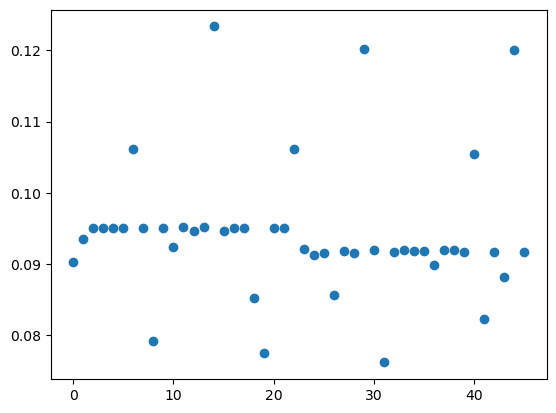

In [66]:
df_stats_temp_test["P2_variance"]
plt.scatter(list(range(len(df_stats_temp_test))),df_stats_temp_test["P1_variance"])

In [67]:
def scaling_df(df, scaler):
    df_stats_scaled = scaler.transform(df)
    df = pd.DataFrame(df_stats_scaled, columns=df.columns)
    return df

scaler_temp = MinMaxScaler()
scaler_fft = MinMaxScaler()
scaler_sf = MinMaxScaler()

scaler_temp.fit(df_stats_temp_train)
scaler_fft.fit(df_stats_fft_train)
scaler_sf.fit(df_sf_train)

df_stats_temp_train = scaling_df(df_stats_temp_train, scaler_temp)
df_stats_fft_train = scaling_df(df_stats_fft_train, scaler_fft)
df_sf_train = scaling_df(df_sf_train, scaler_sf)

df_stats_temp_test = scaling_df(df_stats_temp_test, scaler_temp)
df_stats_fft_test = scaling_df(df_stats_fft_test, scaler_fft)
df_sf_test = scaling_df(df_sf_test, scaler_sf)

#task3
df_stats_temp_test_task3 = scaling_df(df_stats_temp_test_task3, scaler_temp)
df_stats_fft_test_task3 = scaling_df(df_stats_fft_test_task3, scaler_fft)
df_sf_test_task3 = scaling_df(df_sf_test_task3, scaler_sf)

df_stats_temp_train_task3 = scaling_df(df_stats_temp_train_task3, scaler_temp)
df_stats_fft_train_task3 = scaling_df(df_stats_fft_train_task3, scaler_fft)
df_sf_train_task3 = scaling_df(df_sf_train_task3, scaler_sf)

In [68]:
df_stats_temp_test

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P1_kurtosis,P1_skewness,P1_variance,...,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile,P7_kurtosis,P7_skewness,P7_variance,P7_line_integral,P7_clearance_factor
0,0.082119,0.495257,0.899719,0.371555,0.923112,0.188521,0.418134,0.774555,0.755085,0.886305,...,0.359186,0.057270,0.469100,0.607413,0.214772,0.398703,0.520736,0.322713,0.317581,0.469914
1,0.147686,0.193701,0.965394,0.182168,0.600528,0.063933,0.738553,0.469434,0.458853,0.960428,...,0.492324,0.059573,0.562223,0.556326,0.245651,0.416832,0.622854,0.452719,0.327472,0.562473
2,0.152884,0.213351,0.996695,0.152192,0.767194,0.065567,0.475029,0.591421,0.542118,0.996205,...,0.509230,0.052445,0.500018,0.399915,0.415068,0.240401,0.469779,0.469630,0.088054,0.502197
3,0.156664,0.047864,0.996463,0.162786,0.784579,0.061874,0.493017,0.613250,0.572967,0.995939,...,0.518980,0.055686,0.494342,0.445276,0.402197,0.253525,0.520217,0.479423,0.342598,0.495616
4,0.150548,0.185015,0.996230,0.152803,0.775698,0.065674,0.487859,0.585901,0.531035,0.995672,...,0.489727,0.055745,0.497392,0.487430,0.242321,0.318003,0.577750,0.450129,0.336929,0.498653
5,0.142371,0.141254,0.996079,0.152057,0.741710,0.064793,0.478750,0.572821,0.513293,0.995498,...,0.467554,0.060559,0.511408,0.556058,0.231628,0.374559,0.543430,0.428107,0.283785,0.511342
6,127.576711,49.069842,1.215672,1.861598,1.871731,25.221792,63.697667,0.372126,0.077068,1.254651,...,0.479865,2.379473,1.037719,7.609692,8.950544,0.366612,0.493677,0.440315,42.865908,0.393873
7,0.141229,0.095970,0.996862,0.152060,0.736165,0.068747,0.491489,0.570604,0.516818,0.996397,...,0.486337,0.060596,0.506951,0.557067,0.264479,0.351482,0.542209,0.446753,0.337361,0.506871
8,0.052536,0.267645,0.659488,0.307737,0.655742,0.032575,0.818869,0.822629,0.663037,0.626103,...,0.670790,0.061998,0.993372,0.489964,0.070828,0.988469,0.991485,0.635798,0.217366,0.993303
9,0.145077,0.101568,0.997281,0.152046,0.772291,0.065113,0.478699,0.600927,0.538299,0.996878,...,0.448697,0.061286,0.510136,0.554101,0.251152,0.373868,0.535903,0.409500,0.256888,0.509868


In [69]:
df_stats_fft_train = df_stats_fft_train.reset_index(drop=True)
df_stats_temp_train = df_stats_temp_train.reset_index(drop=True)
df_sf_train= df_sf_train.reset_index(drop=True)
#test
df_stats_fft_test = df_stats_fft_test.reset_index(drop=True)
df_stats_temp_test = df_stats_temp_test.reset_index(drop=True)
df_sf_test = df_sf_test.reset_index(drop=True)


df_stats_fft_test_task3 = df_stats_fft_test_task3.reset_index(drop=True)
df_stats_temp_test_task3 = df_stats_temp_test_task3.reset_index(drop=True)
df_sf_test_task3 = df_sf_test_task3.reset_index(drop=True)


df_stats_fft_train_task3 = df_stats_fft_train_task3.reset_index(drop=True)
df_stats_temp_train_task3 = df_stats_temp_train_task3.reset_index(drop=True)
df_sf_train_task3 = df_sf_train_task3.reset_index(drop=True)

In [70]:

df_features_train = pd.concat([df_stats_fft_train,df_stats_temp_train,df_sf_train],axis=1)
df_features_test = pd.concat([df_stats_fft_test,df_stats_temp_test,df_sf_test],axis=1)

df_features_train_task3 = pd.concat([df_stats_fft_train_task3, df_stats_temp_train_task3, df_sf_train_task3], axis=1)

df_features_test_task3 = pd.concat([df_stats_fft_test_task3, df_stats_temp_test_task3, df_sf_test_task3], axis=1)


In [71]:
df_features_train_task3

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.933038,0.880723,-0.773944,1.357762,-0.194847,0.466779,0.822032,-0.111606,0.487579,-0.570760,...,-1.244298,-2.914141,-0.859851,-0.870245,-0.921274,-0.486595,0.055185,-0.919381,-0.247519,0.139060
1,6.936871,0.996156,-0.768958,1.362474,-0.190515,0.522000,0.879904,-0.117659,0.505464,-0.567666,...,-1.175884,-2.957176,-0.916917,-0.928929,-0.925675,-0.505237,0.944815,-0.923821,-0.297850,0.374987
2,6.954507,1.011924,-0.768793,1.362345,-0.190552,0.520620,0.879406,-0.117654,0.505320,-0.567563,...,-1.167623,-2.957145,-0.917152,-0.929166,-0.925670,-0.505299,0.944815,-0.923818,-0.298062,0.374987
3,0.924807,0.878383,-0.775369,1.357691,-0.197287,0.532425,0.863902,-0.113023,0.487128,-0.571643,...,-1.207596,-2.897447,-0.851474,-0.861700,-0.919652,-0.483553,0.944815,-0.917624,-0.242128,0.410599
4,6.976447,1.069273,-0.770401,1.362417,-0.192919,0.532031,0.950398,-0.119082,0.505099,-0.568562,...,-1.160445,-2.885073,-0.886277,-0.897186,-0.918309,-0.495003,0.055185,-0.916310,-0.281386,0.559722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,-4.131647,0.102084,-1.082481,1.569585,-0.236609,0.654825,0.436829,-0.223199,0.797929,-0.747876,...,-1.063472,-3.116664,-1.031175,-1.042831,-0.939531,-0.537978,0.092253,-0.939228,-0.380218,0.074514
527,-4.085857,0.115141,-1.082392,1.569546,-0.236653,0.655636,0.431828,-0.223199,0.797813,-0.747830,...,-1.063456,-3.116644,-1.031118,-1.042776,-0.939529,-0.537951,0.907747,-0.939226,-0.380124,0.929192
528,0.885639,0.365315,-0.984805,1.314491,-0.255448,0.819566,0.408659,-0.076795,0.436348,-0.694865,...,-0.753962,-2.941871,-0.841047,-0.849288,-0.924958,-0.479715,0.055185,-0.922257,-0.217848,0.087869
529,-0.684504,0.390348,-0.986577,1.314894,-0.255364,0.883834,0.340794,-0.076957,0.445475,-0.695852,...,-0.740306,-2.973791,-0.866033,-0.875219,-0.928104,-0.488170,0.055185,-0.925503,-0.237152,0.176898


In [72]:
df_features_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,0.878385,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,0.876131,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,0.871002,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,0.865435,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,0.863301,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,0.756802,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,0.795453,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,0.326300,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,0.277997,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [73]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y['binary_condition']
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [74]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y['binary_condition']

    # Applicazione di SelectKBest con la funzione chi2
    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    # Ottenere i punteggi e le feature selezionate
    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    # Visualizzazione delle feature selezionate e dei loro punteggi
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [75]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y['binary_condition']

    # Addestra un modello Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    # Ottieni le importanze delle feature
    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    # Visualizzazione delle importanze delle feature
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [76]:
df_labels_train = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
df_labels_test = pd.read_csv(f"{path_dataframes}/df_labels_test.csv")


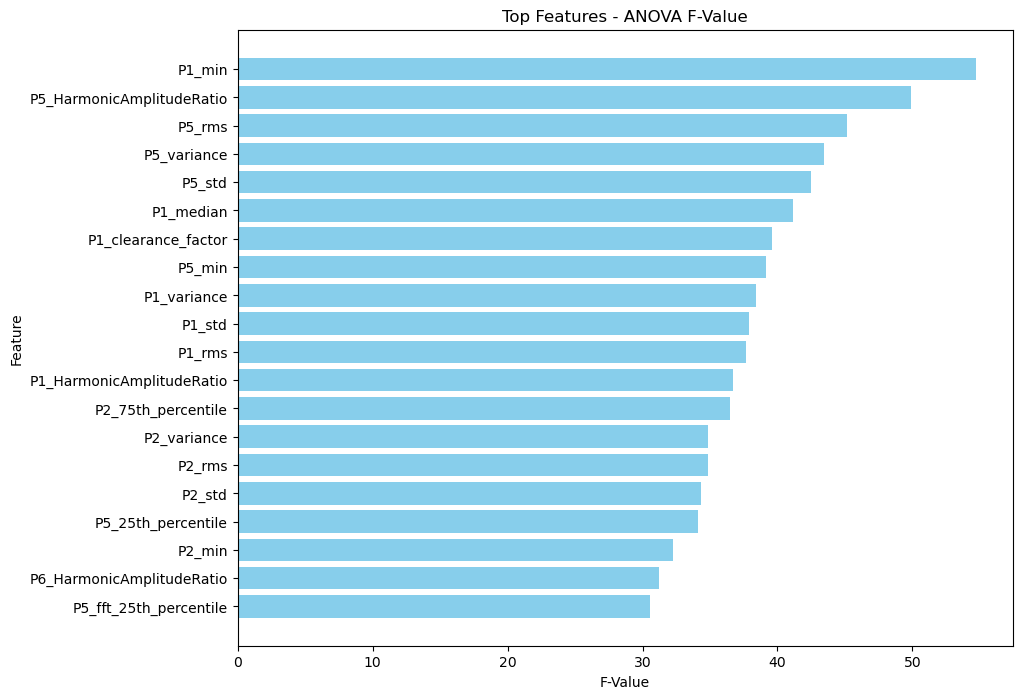

In [77]:
features_train = feature_selection_anova(df_features_train,df_labels_train,20)

# features_test= feature_selection_anova(df_features_test,df_labels_test,10)

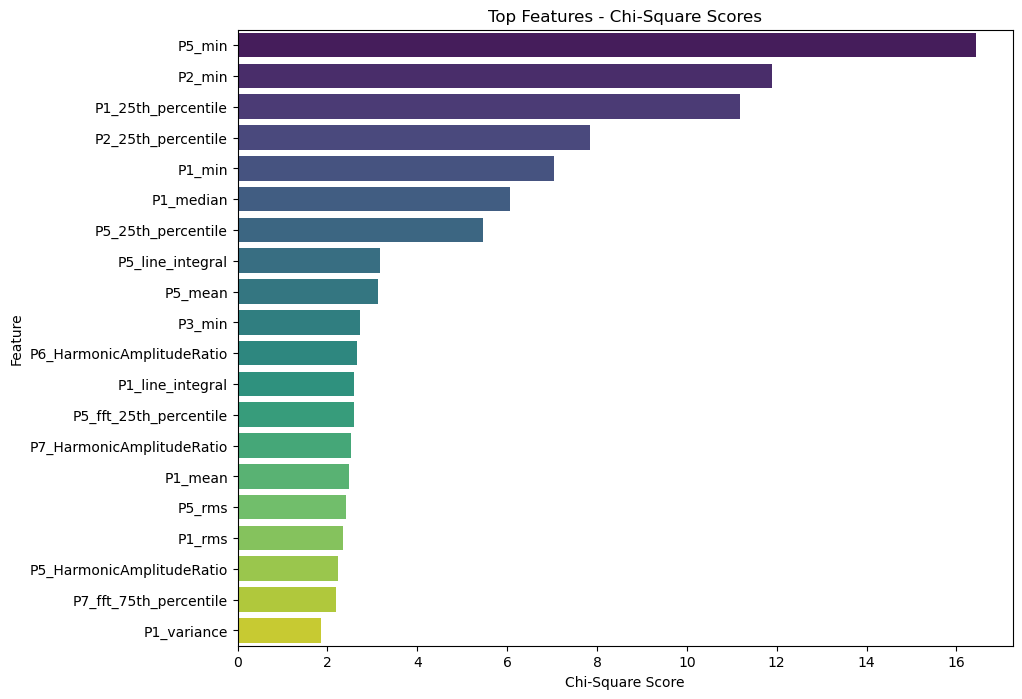

In [78]:
features_chi2_train = feature_selection_chi2(df_features_train,df_labels_train,20)


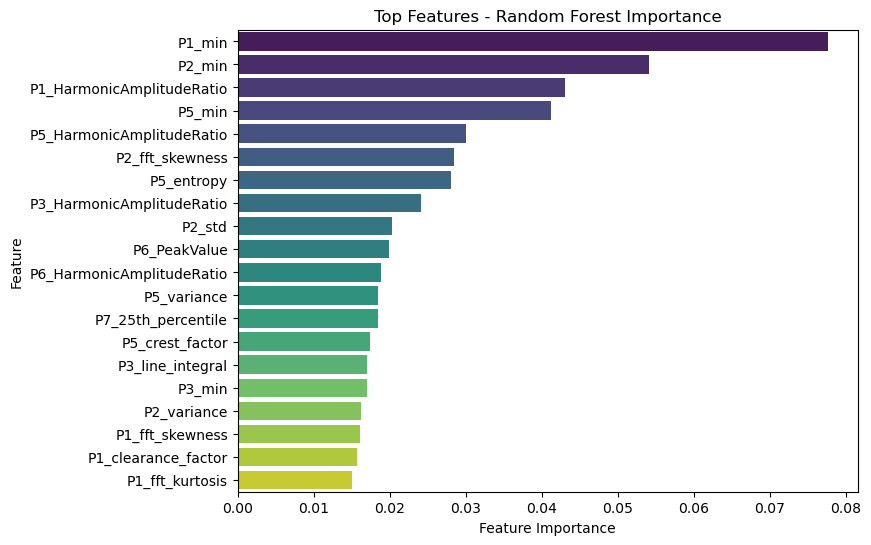

In [79]:
features_rf_train = feature_selection_random_forest(df_features_train,df_labels_train,20)


In [80]:
features_train

array(['P1_min', 'P5_HarmonicAmplitudeRatio', 'P5_rms', 'P5_variance',
       'P5_std', 'P1_median', 'P1_clearance_factor', 'P5_min',
       'P1_variance', 'P1_std', 'P1_rms', 'P1_HarmonicAmplitudeRatio',
       'P2_75th_percentile', 'P2_variance', 'P2_rms', 'P2_std',
       'P5_25th_percentile', 'P2_min', 'P6_HarmonicAmplitudeRatio',
       'P5_fft_25th_percentile'], dtype=object)

In [81]:
df_features_test_task3

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.965981,0.216934,-0.588654,1.317668,-0.007873,0.410467,0.902177,-0.054154,0.869057,-0.450803,...,-1.420717,-2.684354,-0.790410,-0.802030,-0.895758,-0.462138,0.944815,-0.893427,-0.234792,0.679911
1,3.349729,0.120449,-0.581604,1.318214,-0.006511,0.380528,1.056088,-0.056351,0.866260,-0.446038,...,-1.351279,-2.750472,-0.770428,-0.783992,-0.903525,-0.454170,0.963349,-0.901300,-0.193908,0.978158
2,3.374034,0.130630,-0.581471,1.318200,-0.006528,0.378891,1.049325,-0.056414,0.866176,-0.445948,...,-1.350138,-2.751323,-0.768781,-0.782374,-0.903624,-0.453488,0.963349,-0.901399,-0.191692,0.337150
3,0.914766,0.505899,-0.783169,1.361665,-0.181819,0.505328,0.882485,-0.101360,0.488657,-0.576466,...,-1.342502,-2.884790,-0.859489,-0.869720,-0.918802,-0.486373,0.944815,-0.916279,-0.254285,0.319344
4,6.754503,0.482296,-0.777283,1.365106,-0.177977,0.525998,1.003140,-0.107018,0.504473,-0.572829,...,-1.225974,-2.940576,-0.920171,-0.932272,-0.924592,-0.506255,0.055185,-0.922123,-0.304868,0.697717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-5.038303,0.628759,-0.602159,1.204905,-0.271518,1.319864,-0.097179,-0.057888,0.289607,-0.459891,...,-1.763885,-2.814070,-1.009045,-1.031870,-0.908718,-0.442945,0.055185,-0.908557,-0.141213,0.842389
134,-5.018813,0.630132,-0.601968,1.204844,-0.271484,1.319752,-0.097313,-0.057885,0.289617,-0.459763,...,-1.763380,-2.813928,-1.009048,-1.031873,-0.908702,-0.442921,0.055185,-0.908541,-0.141186,0.708845
135,0.919316,0.758981,-0.863756,1.360531,-0.263495,0.433474,0.885959,-0.125775,0.459946,-0.625235,...,-1.124704,-3.028108,-0.878726,-0.888857,-0.935583,-0.493157,0.055185,-0.930873,-0.239825,0.764489
136,7.607791,0.971388,-0.859836,1.366093,-0.258518,0.461913,1.036759,-0.132595,0.481069,-0.622907,...,-0.960222,-3.097773,-0.943394,-0.955663,-0.941483,-0.513803,0.055185,-0.937486,-0.295896,0.326021


In [82]:
df_features_train.to_csv(f"{path_dataframes}/df_train_complete.csv",index_label="index")
df_features_test.to_csv(f"{path_dataframes}/df_test_complete.csv",index_label="index")

#task3
df_features_train_task3.to_csv(f"{path_dataframes}/df_train_task3.csv",index_label="index")
df_features_test_task3.to_csv(f"{path_dataframes}/df_test_task3.csv",index_label="index")

In [83]:
df_features_train = df_features_train[features_rf_train]
df_features_test= df_features_test[features_rf_train]

In [84]:
# df_features_train.to_csv(f"{path_dataframes}/df_train.csv",index_label="index")
# df_features_test.to_csv(f"{path_dataframes}/df_test.csv",index_label="index")

In [85]:
df_features_train

,P1_min,P2_min,P1_HarmonicAmplitudeRatio,P5_min,P5_HarmonicAmplitudeRatio,P2_fft_skewness,P5_entropy,P3_HarmonicAmplitudeRatio,P2_std,P6_PeakValue,P6_HarmonicAmplitudeRatio,P5_variance,P7_25th_percentile,P5_crest_factor,P3_line_integral,P3_min,P2_variance,P1_fft_skewness,P1_clearance_factor,P1_fft_kurtosis
0,0.151379,0.014342,0.500515,0.002855,0.404716,0.467707,0.501952,0.533264,0.764873,0.524031,0.535152,0.989111,0.557123,0.604552,0.246580,0.062465,0.742221,0.387633,0.835385,0.461597
1,0.151707,0.014171,0.496295,0.002856,0.386983,0.461777,0.501219,0.526576,0.764588,0.518759,0.534254,0.970816,0.548320,0.582898,0.251591,0.062465,0.741918,0.385014,0.856063,0.455896
2,0.152334,0.014027,0.492228,0.002595,0.385712,0.453730,0.545951,0.518393,0.774074,0.508576,0.516265,0.942070,0.515050,0.568830,0.232074,0.062465,0.752047,0.380942,0.884633,0.451143
3,0.152786,0.014103,0.492075,0.002830,0.384052,0.448720,0.514646,0.512105,0.773988,0.500853,0.509841,0.964525,0.546530,0.574005,0.235775,0.062465,0.751956,0.377372,0.884439,0.449168
4,0.152716,0.014159,0.490276,0.003023,0.382267,0.445623,0.512726,0.508852,0.767477,0.498663,0.505803,0.975974,0.537448,0.575556,0.248419,0.062465,0.745000,0.375677,0.873784,0.446502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.339054,0.087961,1.000000,0.005946,1.000000,0.451714,0.313649,0.871921,1.000000,0.887973,0.687747,0.504254,0.638680,0.975993,0.227071,0.060095,1.000000,0.470502,0.598945,0.819289
173,0.824787,0.040686,0.717433,0.880071,0.697196,0.970296,0.000000,0.390217,0.675020,0.996007,0.730663,0.781425,0.114359,0.912180,0.327667,0.062464,0.647391,0.919978,0.428516,0.546360
174,0.301860,0.026831,0.362797,0.592579,0.438246,0.702085,0.487628,0.253419,0.606348,0.550350,0.561968,0.577233,0.570718,0.412224,0.321253,0.055959,0.576285,0.609891,0.737837,0.141901
175,0.402989,0.024886,0.000000,0.440788,0.000000,0.868546,0.801111,0.000000,0.599916,0.000000,0.000000,0.497790,0.570237,0.000000,0.358124,0.056165,0.569685,0.798344,0.636050,0.000000


In [86]:
df_features_test

,P1_min,P2_min,P1_HarmonicAmplitudeRatio,P5_min,P5_HarmonicAmplitudeRatio,P2_fft_skewness,P5_entropy,P3_HarmonicAmplitudeRatio,P2_std,P6_PeakValue,P6_HarmonicAmplitudeRatio,P5_variance,P7_25th_percentile,P5_crest_factor,P3_line_integral,P3_min,P2_variance,P1_fft_skewness,P1_clearance_factor,P1_fft_kurtosis
0,0.371555,0.892153,0.534043,0.048438,0.529602,0.696309,0.510393,0.664222,0.826867,0.617778,0.671782,0.741722,0.607413,0.683546,0.284698,0.414883,0.808836,0.722514,0.878211,0.431102
1,0.182168,0.007976,0.524429,0.003761,0.428010,0.632379,0.514892,0.554220,0.705973,0.587278,0.588214,0.987083,0.556326,0.634758,0.276441,0.083922,0.679828,0.402390,0.729427,0.497599
2,0.152192,0.014128,0.493879,0.002697,0.390038,0.455493,0.542544,0.521734,0.771222,0.498518,0.488320,0.944461,0.399915,0.574049,0.235622,0.062465,0.748999,0.382190,0.860323,0.453568
3,0.162786,0.014086,0.494610,0.018448,0.396816,0.464602,0.537476,0.527207,0.772385,0.513779,0.519924,0.928183,0.445276,0.576261,0.237975,0.062464,0.750242,0.385496,0.868178,0.455912
4,0.152803,0.014132,0.491803,0.002987,0.385249,0.449128,0.544531,0.513308,0.771016,0.489897,0.500204,0.949895,0.487430,0.569856,0.235478,0.062465,0.748780,0.377637,0.866098,0.449457
5,0.152057,0.014342,0.497038,0.003052,0.397708,0.457566,0.511642,0.521861,0.766379,0.516504,0.529874,0.991257,0.556058,0.596445,0.244589,0.062465,0.743828,0.381740,0.842303,0.456093
6,1.861598,1.726244,0.443278,1.884693,0.472094,0.662373,-0.883680,0.573696,0.816715,0.542088,0.631157,1.022777,7.609692,0.079709,41.984366,1.543868,0.797862,0.496075,0.921347,0.284268
7,0.152060,0.014342,0.497270,0.002945,0.393583,0.459112,0.509608,0.523912,0.766263,0.515014,0.490255,0.989302,0.557067,0.593212,0.243177,0.062465,0.743704,0.382632,0.838368,0.456525
8,0.307737,0.036904,0.519669,0.592579,0.621510,0.511675,0.693182,0.566072,0.461677,0.870133,0.847797,0.787317,0.489964,0.635212,0.274434,0.054973,0.430374,0.496104,0.715520,0.219519
9,0.152046,0.014222,0.497029,0.002757,0.390251,0.459471,0.504743,0.523750,0.770776,0.521803,0.523654,0.977235,0.554101,0.587033,0.239131,0.062465,0.748523,0.383591,0.864000,0.456875
